In [142]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import wandb
import cv2

In [143]:
# Check if GPU is available
if torch.cuda.is_available():
    # Get the name of the GPU
    gpu_name = torch.cuda.get_device_name(0)  # Assumes you have one GPU, change the index if needed
    print(f"GPU ({gpu_name}) is available.")
else:
    print('GPU not available')
    
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

GPU (NVIDIA GeForce RTX 3070 Ti Laptop GPU) is available.


In [112]:
wandb.init(project="image_colorization", config={
    "architecture": "CNN",
    "dataset": "CIFAR-100_VAL_2017",
})

loss,█▁
loss,1.32865


In [144]:
def normalize_lab(img):
    """
    Normalizes a LAB image within the range of -1 to 1.

    Args:
        img (np.ndarray): A numpy array representing the LAB image.

    Returns:
        np.ndarray: A numpy array representing the normalized LAB image.
    """
    img_l, img_a, img_b = torch.split(img, 1, 0) # SPlit the 3d array into 3 1d arrays
    img_l = (2 * img_l / 100) - 1 # Normalize values between 0 and 1 by dividing by 100
    img_a = (img_a / 128) # Normalize between 0 and 1 as well
    img_b = (img_b / 128) # Same for b channel
    full = torch.stack([img_l, img_a, img_b], dim=1)
    return full[0]

def denormalize_lab(img):
    """
    Denormalizes a LAB image within the range of -1 to 1.

    Args:
        img (np.ndarray): A numpy array representing the LAB image.

    Returns:
        np.ndarray: A numpy array representing the denormalized LAB image.
    """
    img_l, img_a, img_b = torch.split(img, 1, 0)
    img_l = (img_l + 1) * 50
    img_a = (img_a) * 128
    img_b = (img_b) * 128
    full = torch.stack([img_l, img_a, img_b], dim=1)
    return full[0]
    

class ColorizationDataset(Dataset):
    def __init__(self, root_dir, base_images):
        self.root_dir = root_dir
        self.base_images = base_images
        self.bw_folder = os.path.join(root_dir, 'bw')
        self.color_folder = os.path.join(root_dir, 'color')
        self.file_list = os.listdir(base_images)

    def __len__(self):
        return len(self.file_list)
    
    def rgb_to_lab(self, rgb_image):
        rgb_img = np.array(rgb_image)
        lab_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
        lab_img = lab_img.transpose(2,1,0)
        lab_img_torch = torch.from_numpy(lab_img)
        return lab_img_torch[:1,:,:].to(dtype=torch.float32), lab_img_torch[1:,:,:].to(dtype=torch.float32)
        
    def __getitem__(self, idx):
        colored_path = os.path.join(self.color_folder, f'color_{self.file_list[idx]}')
        colored_image = Image.open(colored_path)
        bw_image, ab_channels = self.rgb_to_lab(colored_image)
        return bw_image.to(device), ab_channels.to(device)

In [145]:
# Instantiate the dataset
dataset = ColorizationDataset(root_dir='Data/MS COCO GR_RGB', base_images='Data/MS COCO/MS COCO/val2017')

# Instantiate a PyTorch DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

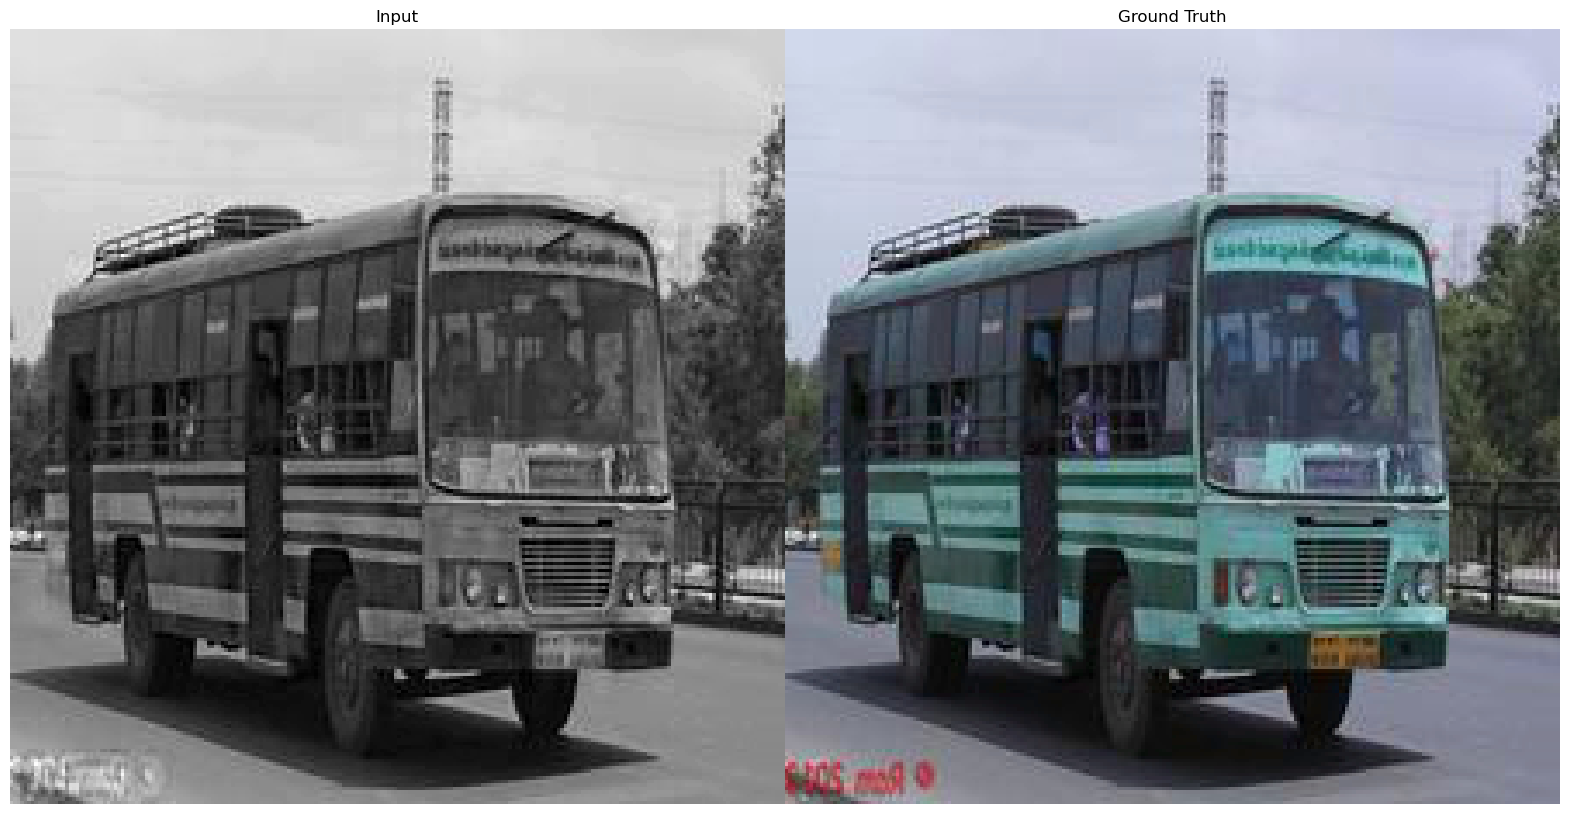

In [146]:
# Show a sample from dataset
# Set a larger figure size
plt.figure(figsize=(20, 15), dpi=100)

# Iterate over the dataloader
for batch_idx, (bw_images, colored_images) in enumerate(dataloader):
    a_channel, b_channel = torch.split(colored_images[0], 1, 0)
    full_norm = torch.stack([bw_images[0], a_channel, b_channel], dim=1).cpu()
    full_denorm = full_norm[0].to(torch.uint8)
    combined_rgb = cv2.cvtColor(full_denorm.numpy().transpose(1,2,0), cv2.COLOR_Lab2RGB) # Convert the colorspace into the RGB format from LAB

    # Plot black and white image
    plt.subplot(1, 2, 1)
    plt.title('Input')
    plt.imshow(np.rot90(combined_rgb[:,:,:1], 3), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title('Ground Truth')
    plt.imshow(np.rot90(combined_rgb, 3))
    plt.axis('off')

    # Adjust spacing to eliminate the gap between subplots
    plt.subplots_adjust(wspace=.001, hspace=0)

    # Display only one batch for demonstration purposes
    break
plt.show()

In [147]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 2, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        return x

# Instantiate the model
gen_model = ColorizationModel()
batch_size = 16
input_shape_gen = (batch_size, 1, 224, 224)
# Print the model summary
gen_model.to(device)
summary(gen_model, input_shape_gen)

Layer (type:depth-idx)                   Output Shape              Param #
ColorizationModel                        [16, 2, 224, 224]         --
├─Sequential: 1-1                        [16, 256, 56, 56]         --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─ReLU: 2-2                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-3                  [16, 64, 224, 224]        128
│    └─Dropout: 2-4                      [16, 64, 224, 224]        --
│    └─Conv2d: 2-5                       [16, 128, 112, 112]       73,856
│    └─ReLU: 2-6                         [16, 128, 112, 112]       --
│    └─BatchNorm2d: 2-7                  [16, 128, 112, 112]       256
│    └─Conv2d: 2-8                       [16, 256, 56, 56]         295,168
│    └─ReLU: 2-9                         [16, 256, 56, 56]         --
│    └─BatchNorm2d: 2-10                 [16, 256, 56, 56]         512
├─Sequential: 1-2                        [16, 2, 224, 224]         --
│ 

In [148]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model_disc = DiscriminatorModel()
# Instantiate the model
input_shape_disc = (batch_size, 3, 224, 224)
# Print the model summary
model_disc.to(device)
summary(model_disc, input_shape_disc)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 1, Conv2d: 2, ReLU: 2, MaxPool2d: 2, Conv2d: 2, ReLU: 2, MaxPool2d: 2]

In [117]:
# Function for logging sample images to wandb
def log_pred(bw_image, pred_image, gt_image):
    a_channel_pred, b_channel_pred = torch.split(pred_image, 1, 0)
    full_norm_pred = torch.stack([bw_image, a_channel_pred, b_channel_pred], dim=1)
    full_denorm_pred = denormalize_lab(full_norm_pred[0]).cpu().to(torch.uint8)
    combined_rgb_pred = cv2.cvtColor(full_denorm_pred.numpy().transpose(1,2,0), cv2.COLOR_Lab2RGB) # Convert the colorspace into the RGB format from LAB
    
    # Convert them all to 8 bit integers
    a_channel_gt, b_channel_gt = torch.split(gt_image, 1, 0) # Split the A and B channels into two separate tensors
    lab_img_gt = torch.stack([bw_image, a_channel_gt, b_channel_gt], dim=1) # Combine them all into the full LAB image
    lab_img_denorm = denormalize_lab(lab_img_gt[0]).cpu().to(torch.uint8)
    combined_rgb = cv2.cvtColor(lab_img_denorm.numpy().transpose(1,2,0), cv2.COLOR_Lab2RGB) # Convert the colorspace into the RGB format from LAB
    
    wandb.log({
        "input_image": wandb.Image(np.rot90(combined_rgb[:,:,:1], 3)),
        "reconstruction_image": wandb.Image(np.rot90(combined_rgb_pred, 3)),
        "ground_truth_image": wandb.Image(np.rot90(combined_rgb, 3)),
    })
    
# Define the loss function and optimizer
criterion = nn.BCEloss()

# Adam optimizer for best performance
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
eps = 1e-6

In [118]:
for epoch in range(num_epochs):
    for batch_idx, (bw_images, colored_images) in enumerate(dataloader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = torch.clamp(model(bw_images), min=-128, max=127)
        outputs = torch.where(outputs == 0.0, eps, outputs) 
        torch.autograd.set_detect_anomaly(True)

        # Compute the MSE loss
        loss = new_color_loss(outputs, colored_images, bw_images, alpha=1.0, beta=1.0, gamma=1.0)
        wandb.log({"loss":loss})

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        if batch_idx % 5 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
        if batch_idx % 80 == 0:
            log_pred(bw_images[0], outputs[0], colored_images[0])
            

# Save the trained model
torch.save(model.state_dict(), 'colorization_model_4.pth')

Epoch 0, Batch 0, Loss: 3.916966676712036
Epoch 0, Batch 5, Loss: 1.6612170934677124
Epoch 0, Batch 10, Loss: 1.371252417564392
Epoch 0, Batch 15, Loss: 1.2105554342269897
Epoch 0, Batch 20, Loss: 1.0169631242752075
Epoch 0, Batch 25, Loss: 0.8266134262084961
Epoch 0, Batch 30, Loss: 0.5961722731590271
Epoch 0, Batch 35, Loss: 0.3695272207260132
Epoch 0, Batch 40, Loss: 0.2475278675556183
Epoch 0, Batch 45, Loss: 0.27259916067123413
Epoch 0, Batch 50, Loss: 0.28711190819740295
Epoch 0, Batch 55, Loss: 0.2467719316482544
Epoch 0, Batch 60, Loss: 0.1979670375585556
Epoch 0, Batch 65, Loss: 0.20299378037452698
Epoch 0, Batch 70, Loss: 0.18751728534698486
Epoch 0, Batch 75, Loss: 0.17399737238883972
Epoch 0, Batch 80, Loss: 0.24039097130298615
Epoch 0, Batch 85, Loss: 0.21084104478359222
Epoch 0, Batch 90, Loss: 0.18020117282867432
Epoch 0, Batch 95, Loss: 0.18818721175193787
Epoch 0, Batch 100, Loss: 0.158169224858284
Epoch 0, Batch 105, Loss: 0.1667456328868866
Epoch 0, Batch 110, Loss: 

In [122]:
# # Display the images in the current batch
#     bw_image = to_pil_image(((((bw_images[0] + 1) / 2) * 255) - 128))
#     colored_image = to_pil_image(((((colored_images[0] + 1) / 2) * 255) - 128)) # De-normalized image

# Set a larger figure size
plt.figure(figsize=(20, 15), dpi=100)

pretrained_dict = torch.load('colorization_model_3.pth')

# Set the model to evaluation mode
model = ColorizationModel().to(device)
model.load_state_dict(pretrained_dict)
model.eval()  # Set model to evaluation mode (no weights being adjusted)

# Iterate over the dataloader
for batch_idx, (bw_images, colored_images) in enumerate(dataloader):
    #
    # Predict the colorized image
    #output = torch.clamp(model(bw_images), min=-128, max=127).cpu().to(torch.uint8) # Adjust input shape if needed
    output = torch.clamp(model(bw_images), min=-128, max=127).cpu()
    print(f'Pred Min A Channel: {torch.min(output[0][0])}')
    print(f'Pred Max A Channel: {torch.max(output[0][0])}')
    # Display the images in the current batch
    bw_item = bw_images[0].cpu() # Get the L channel
    colored_item = colored_images[0].cpu() # Get the A and B channels
    a_channel, b_channel = torch.split(colored_item, 1, 0) # Split the A and B channels into two separate tensors
    lab_img = torch.stack([bw_item, a_channel, b_channel], dim=1) # Combine them all into the full LAB image
    combined_tensor = lab_img.cpu().numpy() # Put the tensor in the cpu, the convert it to numpy
    combined_rgb = cv2.cvtColor(combined_tensor[0].transpose(1,2,0).astype(np.uint8), cv2.COLOR_Lab2RGB) # Convert the colorspace into the RGB format from LAB
    
    # Display the images in the current batch
    colored_item_pred = output[0] # Get the A and B channels
    print(f'GT Min A Channel: {torch.min(colored_item[0])}')
    print(f'GT Max A Channel: {torch.max(colored_item[0])}')
    a_channel_pred, b_channel_pred = torch.split(colored_item_pred, 1, 0) # Split the A and B channels into two separate tensors
    lab_img_pred = torch.stack([bw_item, a_channel_pred, b_channel_pred], dim=1) # Combine them all into the full LAB image
    combined_tensor_pred = lab_img_pred.cpu().detach().numpy() # Put the tensor in the cpu, the convert it to numpy
    combined_rgb_pred = cv2.cvtColor(combined_tensor_pred[0].transpose(1,2,0).astype(np.uint8), cv2.COLOR_Lab2RGB) # Convert the colorspace into the RGB format from LAB
    
    # Plot black and white image
    plt.subplot(1,3,1)
    plt.title('Input')
    plt.imshow(np.rot90(combined_rgb[:,:,:1], 3), cmap='gray')  # Access the tensor data with bw_image[0]
    plt.axis('off')

    # Plot colored image
    plt.subplot(1,3,2)
    plt.title('Reconstruction')
    plt.imshow(np.rot90(combined_rgb_pred, 3))
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.title('Ground Truth')
    plt.imshow(np.rot90(combined_rgb, 3))
    plt.axis('off')

    # Adjust spacing to eliminate the gap between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0)

    # Display the batch
    plt.show()

    # Display only one batch for demonstration purposes
    break


RuntimeError: Error(s) in loading state_dict for ColorizationModel:
	Missing key(s) in state_dict: "encoder.4.weight", "encoder.4.bias", "decoder.4.weight", "decoder.4.bias". 
	Unexpected key(s) in state_dict: "encoder.6.weight", "encoder.6.bias", "encoder.8.weight", "encoder.8.bias", "encoder.8.running_mean", "encoder.8.running_var", "encoder.8.num_batches_tracked", "encoder.2.running_mean", "encoder.2.running_var", "encoder.2.num_batches_tracked", "encoder.3.weight", "encoder.3.bias", "encoder.5.weight", "encoder.5.bias", "encoder.5.running_mean", "encoder.5.running_var", "encoder.5.num_batches_tracked", "decoder.5.weight", "decoder.5.bias", "decoder.5.running_mean", "decoder.5.running_var", "decoder.5.num_batches_tracked", "decoder.6.weight", "decoder.6.bias", "decoder.2.running_mean", "decoder.2.running_var", "decoder.2.num_batches_tracked", "decoder.3.weight", "decoder.3.bias". 
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for encoder.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([128, 64, 4, 4]).
	size mismatch for decoder.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).

<Figure size 2000x1500 with 0 Axes>

In [252]:
# # Set a larger figure size
# plt.figure(figsize=(10, 12), dpi=100)

# pretrained_dict = torch.load('colorization_model_3.pth')

# # Set the model to evaluation mode
# model = ColorizationModel().to(device)
# model.load_state_dict(pretrained_dict)
# model.eval()  # Set model to evaluation mode (no weights being adjusted)

# # Iterate over the dataloader
# for batch_idx, (bw_images, colored_images) in enumerate(dataloader):
#     #
#     bw_image = bw_images[1][0]

#     # Predict the colorized image
#     output = colored_images[1][0].transpose(2, 0)  # Adjust input shape if needed
#     a_channel, b_channel = torch.split(output, 1, dim=0)
#     full_lab = torch.stack([bw_image[0], a_channel[0], b_channel[0]], dim=0)
#     full_np = full_lab.detach().cpu().numpy().transpose(1, 2, 0)
#     image_rgb = np.array(cv2.cvtColor(full_np, cv2.COLOR_LAB2RGB))
#     image_rgb = image_rgb
#     plt.imshow(image_rgb)
#     plt.axis('off')
#     plt.show()

#     # Display only one batch for demonstration purposes
#     break


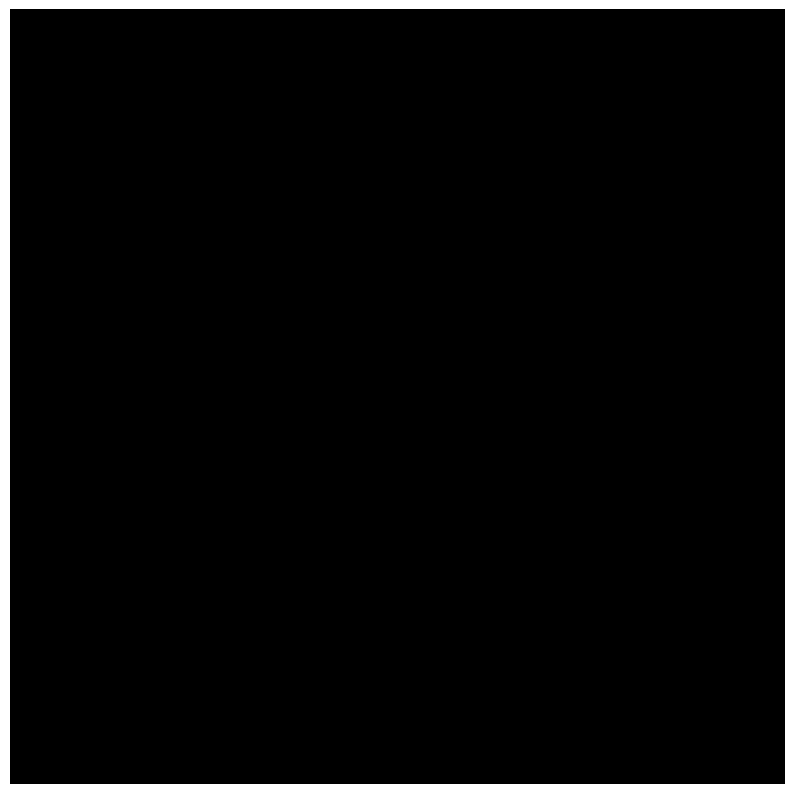

In [302]:
# Set a larger figure size
plt.figure(figsize=(10, 12), dpi=100)

# Iterate over the dataloader
for batch_idx, (bw_images, colored_images) in enumerate(dataloader):
    # Extract individual images from the batch
    bw_image = bw_images[0].transpose(2, 0).cpu()
    colored_image = colored_images[0].transpose(2, 0).cpu()
    
    # Denormalize the colored image to the range [0, 255]
    colored_image_denorm = ((colored_image + 1.0) * 128).numpy()

    # Concatenate the images for LAB conversion
    lab_np_normalized = np.concatenate((bw_image, colored_image_denorm), axis=2)
    
    # Convert LAB to RGB
    rgb_np_normalized = cv2.cvtColor(lab_np_normalized, cv2.COLOR_LAB2RGB)

    # Convert to uint8 for displaying
    rgb_np = rgb_np_normalized.astype(np.uint8) * 255

    # Ensure the shape is (height, width, channels)    
    rgb_image = Image.fromarray(rgb_np)

    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

    # Display only one batch for demonstration purposes
    break
